In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,InputLayer,Flatten,BatchNormalization,Input,Dropout,RandomFlip,RandomRotation,Resizing,Rescaling,RandomContrast,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Layer,Add,Activation
import tensorflow_probability as tfp
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy,FalsePositives,FalseNegatives,TruePositives,TrueNegatives,Precision,Recall,AUC,CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L2,L1
import sklearn
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
from tensorflow.train import BytesList,FloatList,Int64List
from tensorflow.train import Example,Features,Feature

from tensorflow.keras.models import Model

In [23]:
train_directory=r'/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train'
val_directory=r'/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test'

Class_Names=['angry','happy','sad']

Configuration={
    'BATCH_SIZE':32,
    'IM_SIZE':256,
    'Learning_Rate':0.001,
    'N_Epochs':20,
    'Dropout_Rate':0.0,
    'Regularization_Rate':0.0,
    'N_Filters':6,
    'Kernel_Size':3,
    'N_Strides':1,
    'Pool_Size':2,
    'N_Dense_1':1024,
    'N_Dense_2':128,
    'Num_Classes':3,
    'Patch_Size':16
    
}

In [24]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=Class_Names,
    color_mode='rgb',
    batch_size=Configuration['BATCH_SIZE'],
    image_size=(Configuration['IM_SIZE'],Configuration['IM_SIZE']),
    shuffle=True,
    seed=99,

)

Found 6799 files belonging to 3 classes.


In [25]:
 val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=Class_Names,
    color_mode='rgb',
    batch_size=Configuration['BATCH_SIZE'],
    image_size=(Configuration['IM_SIZE'],Configuration['IM_SIZE']),
    shuffle=True,
    seed=99,

)

Found 2278 files belonging to 3 classes.


In [26]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [27]:
import cv2
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image=cv2.resize(test_image,(Configuration['IM_SIZE'],Configuration['IM_SIZE']))

In [28]:
test_image.shape

(256, 256, 3)

In [29]:
#test_image


In [30]:
list=[[[1,2,3],
      [4,5,6],
      [7,8,9],
      [10,11,12]],[[1,2,3],
      [4,5,6],
      [7,8,9],
      [10,11,12]]]
list=tf.convert_to_tensor(list)
list.shape

TensorShape([2, 4, 3])

In [31]:
 n = 10
  # images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100
images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]
images=tf.convert_to_tensor(images)
print(images.shape)
# We generate two outputs as follows:
# 1. 3x3 patches with stride length 5
# 2. Same as above, but the rate is increased to 2
gy=tf.image.extract_patches(images=images,
                       sizes=[1, 3, 3, 1],
                       strides=[1, 3, 3, 1],
                       rates=[1, 1, 1, 1],
                       padding='VALID')
print(gy[0,0,0,])


(1, 10, 10, 1)
tf.Tensor([ 1  2  3 11 12 13 21 22 23], shape=(9,), dtype=int32)


In [32]:
patches=tf.image.extract_patches(images=tf.expand_dims(test_image,axis=0),
                                sizes=[1,16,16,1],
                                strides=[1,16,16,1],
                                rates=[1,1,1,1],
                                padding='VALID')

In [33]:
test_image.shape,patches.shape

((256, 256, 3), TensorShape([1, 16, 16, 768]))

In [34]:
#test_image[:16,:16,]==tf.reshape(patches[0,0,0,],[16,16,-1])

In [35]:
patches.shape,test_image.shape

(TensorShape([1, 16, 16, 768]), (256, 256, 3))

In [36]:
#test_image[:16,:16]==tf.reshape(patches[0,0,:],[16,16,-1])

In [37]:
patches=tf.reshape(patches,(patches.shape[0],-1,768))
patches.shape

TensorShape([1, 256, 768])

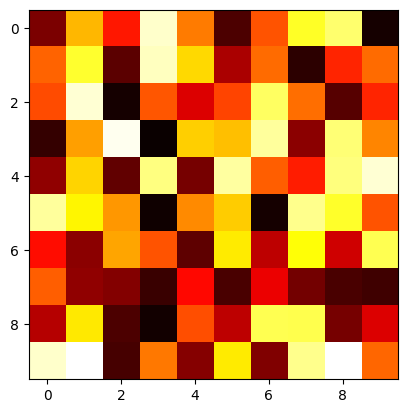

In [38]:
data = np.random.rand(10, 10)

plt.imshow(data, cmap='hot', interpolation='nearest')

In [39]:
patches.shape

TensorShape([1, 256, 768])

In [40]:
patches[0,].shape


TensorShape([256, 768])

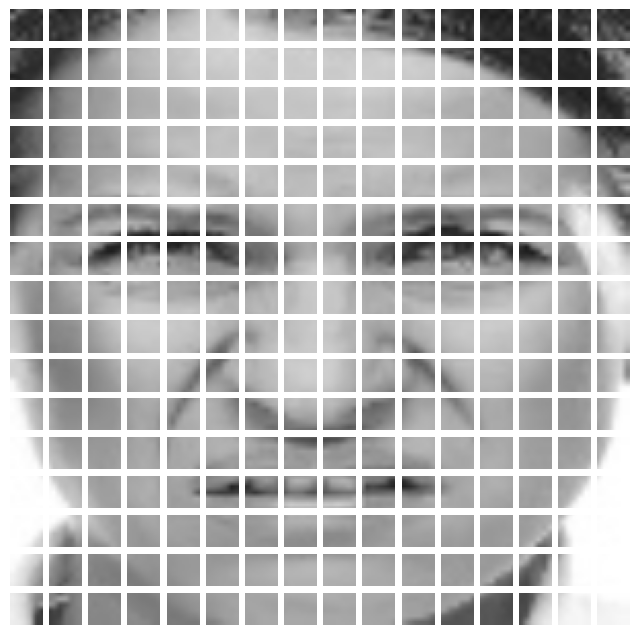

In [41]:
plt.figure(figsize=(8,8))
k=0
for i in range(256):
    #for j in range(16):
        
        ax=plt.subplot(16,16,k+1)

        
        plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
        plt.axis('off')
        k+=1


In [145]:
class PatchEncoder(Layer):
    def __init__(self,N_patches,Hidden_size):
        super(PatchEncoder,self).__init__(name='patch_encoder')
        
        self.linear_projection=Dense(Hidden_size)
        self.positional_embedding=tf.keras.layers.Embedding(N_patches,Hidden_size)
        self.N_patches=N_patches
    def call(self,x):
        patches=tf.image.extract_patches(images=x,
                                        sizes=[1,Configuration['Patch_Size'],Configuration['Patch_Size'],1],
                                        strides=[1,Configuration['Patch_Size'],Configuration['Patch_Size'],1],
                                        rates=[1,1,1,1],
                                        padding='VALID')
        
        patches=tf.reshape(patches,(tf.shape(patches)[0],256,patches.shape[-1]))
        embedding_input=tf.range(start=0,limit=self.N_patches,delta=1)
        output=self.linear_projection(patches)+self.positional_embedding(embedding_input)

        
        return output

In [146]:
patch_enc=PatchEncoder(256,768)
patch_enc(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[-0.02963194,  0.03218381, -0.01997473, ..., -0.02642386,
         -0.01164066, -0.01733284],
        [-0.03766276, -0.0293215 ,  0.04980913, ...,  0.00771346,
         -0.00678194,  0.03569717],
        [ 0.01170293,  0.01748331, -0.04489943, ..., -0.00902652,
          0.01152397, -0.0011897 ],
        ...,
        [-0.02153008,  0.02898056, -0.03011873, ...,  0.04906093,
         -0.00223164,  0.01433175],
        [-0.03588179,  0.04790611,  0.04687837, ..., -0.02388494,
          0.01859162, -0.01034405],
        [ 0.01188935,  0.03890764,  0.02738992, ..., -0.0210713 ,
         -0.03759908, -0.0477744 ]],

       [[-0.02963194,  0.03218381, -0.01997473, ..., -0.02642386,
         -0.01164066, -0.01733284],
        [-0.03766276, -0.0293215 ,  0.04980913, ...,  0.00771346,
         -0.00678194,  0.03569717],
        [ 0.01170293,  0.01748331, -0.04489943, ..., -0.00902652,
          0.01152397, -0.0011897 ],
        ...

In [147]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000,64,input_length=10))
input_array=np.random.randint(1000,size=(32,10))
print(input_array.shape)
model.compile('rmsprop','mse')
output_array=model.predict(input_array)
print(output_array.shape)

(32, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
(32, 10, 64)


In [148]:
tf.constant([[1,2],[0,3]])+tf.constant([[1],[4]])

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 3],
       [4, 7]], dtype=int32)>

In [149]:
class TransformerEncoder(Layer):
    def __init__(self,N_Heads,Hidden_Size):
        super(TransformerEncoder,self).__init__(name='patch_encoder')
        
        self.layer_norm1=tf.keras.layers.LayerNormalization()
        self.layer_norm2=tf.keras.layers.LayerNormalization()
        
        self.multi_head_att=tf.keras.layers.MultiHeadAttention(N_Heads,Hidden_Size)
        
        
        self.dense1=Dense(Hidden_Size,activation=tf.nn.gelu)
        self.dense2=Dense(Hidden_Size,activation=tf.nn.gelu)
        
    def call(self,input):
        x_1=self.layer_norm1(input)
        x_1=self.multi_head_att(x_1,x_1)

        x_1=Add()([x_1,input])

        x_2=self.layer_norm2(x_1)
        x_2=self.dense1(x_2)
        output=self.dense2(x_2)
        output=Add()([output,x_1])

        return output

        
        

In [150]:
trans_enc=TransformerEncoder(8,768)
trans_enc(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [151]:
class CustomConv2D(Layer):
    def __init__(self,n_filters,kernel_size,n_strides,padding='valid'):
        super(CustomConv2D,self).__init__(name='custom_conv2d')
        
        self.conv=Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation='relu',
                strides=n_strides,
                padding=padding)
        
        self.batch_norm=BatchNormalization()
        
    def call(self,x,training=True):
            x=self.conv(x)
            x=self.batch_norm(x.training)
            
            return x
    

    
    
    
class ResidualBlock(Layer):
    def __init__(self,n_channels,n_strides=1):
        super(ResidualBlock,self).__init__(name='res_block')
        
        self.dotted=(n_strides!=1)
        
        self.custom_conv_1=CustomConv2D(n_channels,3,n_strides,padding='same')
        self.custom_conv_2=CustomConv2D(n_channels,3,1,padding='same')
        
        self.activation=Activation('relu')
        
        if self.dotted:
            self.custom_conv_3=CustomConv2D(n_channels,1,n_strides)
            
    def call(self,input,training):
            
            x=self.custom_conv_1.call(input,training)
            x=self.custom_conv_2(x,training)
            if self.dotted:
                x_add=self.custom_conv_3(input,training)
                x_add=Add()([x,x_add])
            else:
                x_add=Add()([x,input])
                
            return self.activation(x_add)

In [152]:
class ViT(Model):
    def __init__(self,N_Heads,Hidden_Size,N_Patches,N_Layers,N_Dense_Units):
        super(ViT,self).__init__(name='Vision_transformer')
        
        self.N_Layers=N_Layers
        self.patch_encoder=PatchEncoder(N_Patches,Hidden_Size)
        self.trans_encoders=[ TransformerEncoder(N_Heads,Hidden_Size)  for _ in range(N_Layers)]
        self.dense_1=Dense(N_Dense_Units,tf.nn.gelu)
        self.dense_2=Dense(N_Dense_Units,tf.nn.gelu)
        self.dense_3=Dense(Configuration["Num_Classes"],activation='softmax')
      

    def call(self,input,training=True):

        x=self.patch_encoder(input)
        

        for i in range(self.N_Layers):
            x=self.trans_encoders[i](x)

        x=Flatten()(x)
        x=self.dense_1(x)
        x=self.dense_2(x)

        return self.dense_3(x)

In [153]:
vit=ViT(8,768,256,4,1024)
vit(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
       [0.23291925, 0.22896966, 0.538111  ],
      

In [137]:
vit.summary()

Model: "Vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder                   │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder                   │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder                   │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder                   │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)